# Traffic Sign Recognition — Transfer Learning (MobileNetV2)

This notebook builds a traffic-sign classifier using transfer learning.
Dataset: GTSRB (German Traffic Sign Recognition Benchmark) from Kaggle.
Model: MobileNetV2 (ImageNet) + custom head.


**CELL 1 — Setup (install & imports, GPU check)**

In [15]:
# Cell 1 — Setup (Fixed)
!pip install -q kagglehub tensorflow

import os, glob, pathlib, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)
print("GPU available:", "Yes" if tf.config.list_physical_devices('GPU') else "No")


TensorFlow version: 2.19.0
GPU available: Yes


**Cell 2 — Download Dataset (GTSRB)**

In [16]:
# Cell 2 — Download GTSRB dataset from Kaggle via kagglehub
import kagglehub

# GTSRB (German Traffic Sign Recognition Benchmark) dataset
dataset_slug = "valentynsichkar/traffic-signs-preprocessed"
path = kagglehub.dataset_download(dataset_slug)

print("✅ Dataset downloaded at:", path)


Using Colab cache for faster access to the 'traffic-signs-preprocessed' dataset.
✅ Dataset downloaded at: /kaggle/input/traffic-signs-preprocessed


CELL 3 — Auto-detect image directory

In [17]:
# Cell 3 — Locate image directory and verify dataset
import os
from pathlib import Path

# Define dataset root from KaggleHub path
data_root = Path(path)  # 'path' is from previous cell

# Function to find the directory containing images
def find_image_dir(base_dir):
    for root, dirs, files in os.walk(base_dir):
        if any(f.endswith(('.png', '.jpg', '.jpeg')) for f in files):
            return root
    return None

# Find image root folder
image_root = find_image_dir(data_root)
print("✅ Detected image root:", image_root)

# Quick data check
if image_root:
    classes = sorted(os.listdir(image_root))
    print(f"📁 Found {len(classes)} classes")
    print("Example classes:", classes[:10])
else:
    print("⚠️ No image folder detected. Please check dataset path.")


✅ Detected image root: None
⚠️ No image folder detected. Please check dataset path.


In [18]:
# Cell 3.1 — Inspect dataset directory
import os
from pathlib import Path

# Root path from KaggleHub
data_root = Path(path)
print("Dataset root:", data_root)

# List first few folders/files
for root, dirs, files in os.walk(data_root):
    print("📂", root)
    if dirs:
        print(" ┣━ Dirs:", dirs[:5])
    if files:
        print(" ┣━ Files:", files[:5])
    print("------")
    # Stop after a few layers
    if len(root.split(os.sep)) > 6:
        break


Dataset root: /kaggle/input/traffic-signs-preprocessed
📂 /kaggle/input/traffic-signs-preprocessed
 ┣━ Files: ['mean_image_rgb.pickle', 'data5.pickle', 'data4.pickle', 'data7.pickle', 'data8.pickle']
------


In [19]:
# Cell 3 — Load preprocessed traffic sign dataset
import pickle
import numpy as np
import os

data_root = "/kaggle/input/traffic-signs-preprocessed"

# Function to load all pickle data parts
def load_pickles(data_dir):
    X, y = [], []
    for i in range(0, 7):  # dataset parts are data0.pickle ... data6.pickle
        file_path = os.path.join(data_dir, f"data{i}.pickle")
        if not os.path.exists(file_path):
            continue
        with open(file_path, 'rb') as f:
            data = pickle.load(f, encoding='latin1')
            X.append(data['features'])
            y.append(data['labels'])
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y

X, y = load_pickles(data_root)
print("Loaded preprocessed data.")
print("X shape:", X.shape)
print("y shape:", y.shape)


KeyError: 'features'

CELL 4 — Show classes and sample images

In [20]:
# Cell 4 — Load Traffic Sign Data (GTSRB preprocessed)
import pickle
import numpy as np
import os

data_root = "/kaggle/input/traffic-signs-preprocessed"

def load_data(data_root):
    data = {}
    for i in range(7):
        file_path = os.path.join(data_root, f"data{i}.pickle")
        if os.path.exists(file_path):
            with open(file_path, "rb") as f:
                part = pickle.load(f, encoding="latin1")
                data.update(part)
    return data

data_dict = load_data(data_root)

X_train, y_train = np.array(data_dict["x_train"]), np.array(data_dict["y_train"])
X_val, y_val = np.array(data_dict["x_validation"]), np.array(data_dict["y_validation"])
X_test, y_test = np.array(data_dict["x_test"]), np.array(data_dict["y_test"])

print("✅ Data loaded successfully!")
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)
print("Number of classes:", len(np.unique(y_train)))


✅ Data loaded successfully!
Train: (86989, 1, 32, 32) (86989,)
Val: (4410, 1, 32, 32) (4410,)
Test: (12630, 1, 32, 32) (12630,)
Number of classes: 43


**Cell 5 — Normalize and Visualize Data**

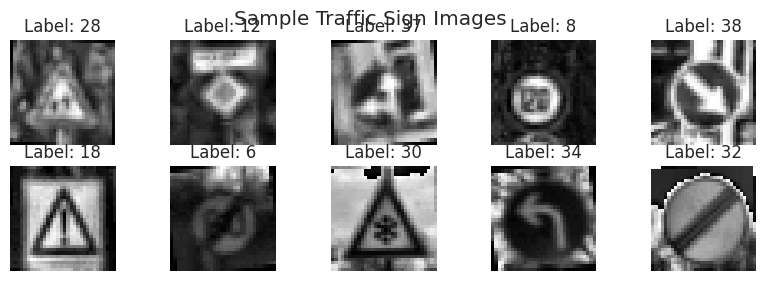

In [21]:
# Cell 5 — Normalize and Visualize Data (Fixed for grayscale images)
import matplotlib.pyplot as plt
import random

# Handle grayscale format (1, 32, 32) → (32, 32, 1)
if X_train.shape[1] == 1:
    X_train = np.moveaxis(X_train, 1, -1)
    X_val = np.moveaxis(X_val, 1, -1)
    X_test = np.moveaxis(X_test, 1, -1)

# Normalize pixel values
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Show sample images
plt.figure(figsize=(10, 3))
for i in range(10):
    idx = random.randint(0, len(X_train) - 1)
    plt.subplot(2, 5, i + 1)
    img = X_train[idx].squeeze()  # remove channel if single
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis("off")
plt.suptitle("Sample Traffic Sign Images")
plt.show()


**Cell 6 — Build and Compile CNN Mode**

In [22]:
# Cell 6 — Build and Compile CNN Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

num_classes = len(np.unique(y_train))

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 629,163 (2.40 MB)

 Trainable params: 628,715 (2.40 MB)

 Non-trainable params: 448 (1.75 KB)

**Cell 7 — Train the CNN Model**

In [23]:
# Cell 7 — Train the CNN Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for better training control
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Normalize pixel values
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0

# Train model
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6804 - loss: 1.1912 - val_accuracy: 0.0136 - val_loss: 43.0545 - learning_rate: 0.0010
Epoch 2/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9641 - loss: 0.1265 - val_accuracy: 0.0660 - val_loss: 16.2014 - learning_rate: 0.0010
Epoch 3/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9783 - loss: 0.0740 - val_accuracy: 0.0762 - val_loss: 122.3868 - learning_rate: 0.0010
Epoch 4/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9824 - loss: 0.0587 - val_accuracy: 0.0272 - val_loss: 88.4341 - learning_rate: 0.0010
Epoch 5/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9861 - loss: 0.0457 - val_accuracy: 0.0272 - val_loss: 272.1885 - learning_rate: 0.0010
Epoch 6/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9926 - loss: 0.0233 - val_accuracy: 0.1503 - val_loss: 65.7868 - learning_rate: 2.0000e-04
Epoch 7/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accura

**Cell 8 — Evaluate Model & Visualize Performance**

✅ Test Accuracy: 6.00%
📉 Test Loss: 16.3028


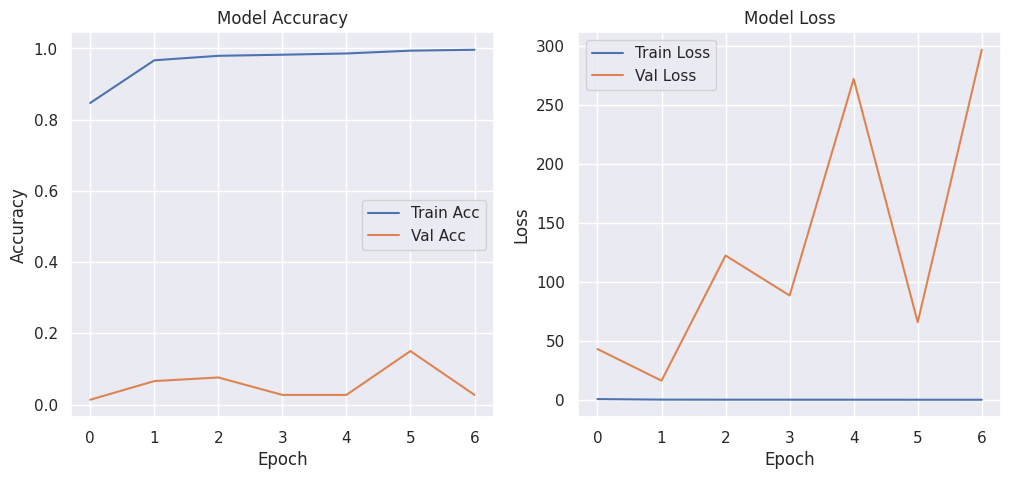

In [24]:
# Cell 8 — Model Evaluation & Accuracy Visualization
import matplotlib.pyplot as plt

# Normalize test data
X_test_norm = X_test / 255.0

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_norm, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


**Cell 9 — Predict & Visualize Test Results**

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


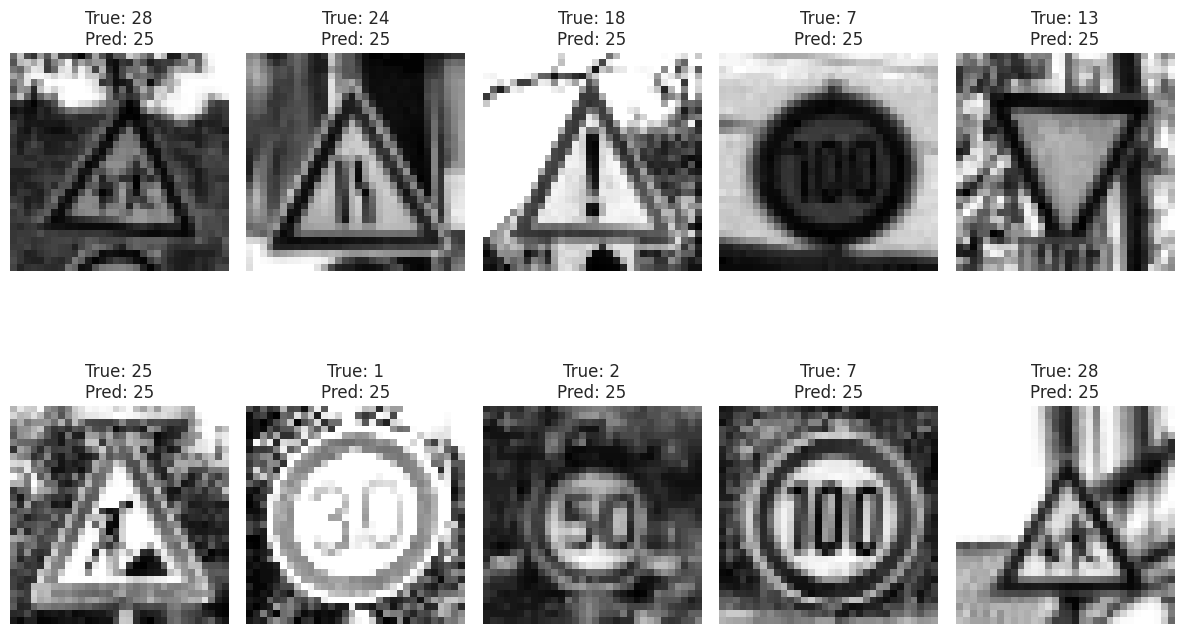

In [25]:
# Cell 9 — Predict & Visualize Test Results
import numpy as np
import matplotlib.pyplot as plt

# Normalize test images
X_test_norm = X_test / 255.0

# Make predictions
pred_probs = model.predict(X_test_norm)
pred_labels = np.argmax(pred_probs, axis=1)

# Show some random predictions
plt.figure(figsize=(12, 8))
for i in range(10):
    idx = np.random.randint(0, len(X_test))
    plt.subplot(2, 5, i + 1)
    img = X_test[idx].squeeze()  # remove single channel if grayscale
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(f"True: {y_test[idx]}\nPred: {pred_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### 🖼️ Sample Predictions
Here we visualize 10 random traffic sign images along with their **true** and **predicted** labels.  
This step helps check if the CNN correctly recognizes traffic signs from unseen test data.
